In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

import os
import yaml

from google.cloud import bigquery
from google.cloud import aiplatform as vertex_ai

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [2]:
plt.rcParams['font.family'] = 'DejaVu Sans'

In [3]:
# Load configuration
CONFIG_PATH = "../configs/config.yaml"
with open(CONFIG_PATH, 'r') as config_file:
    config = yaml.safe_load(config_file)

# Paths from configuration
PROJECT_ID = config['gcp']['project_id']
LOCATION = config['gcp']['location']
TENSORBOARD_NAME = f"projects/{PROJECT_ID}/locations/{LOCATION}/tensorboards/149744687610068992"


In [4]:
# Set up experiment tracking
vertex_ai.init(
    project=PROJECT_ID,
    location=LOCATION,
    staging_bucket="gs://experiment_tracking_bucket",
    experiment="forcasting-experiment",
    experiment_tensorboard=vertex_ai.Tensorboard(TENSORBOARD_NAME)
)

In [5]:
# Set up BigQuery client
client = bigquery.Client(project="mlops-retail-quant")

# Query the data from BigQuery
query = """
SELECT * FROM `mlops-retail-quant.retail_dataset.raw_data_table`
"""
df = client.query(query).to_dataframe()

# Display the dataframe
df.head()


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536414,22139,None,56,2010-12-01 11:52:00+00:00,0.0,<NA>,United Kingdom
1,536545,21134,None,1,2010-12-01 14:32:00+00:00,0.0,<NA>,United Kingdom
2,536546,22145,None,1,2010-12-01 14:33:00+00:00,0.0,<NA>,United Kingdom
3,536547,37509,None,1,2010-12-01 14:33:00+00:00,0.0,<NA>,United Kingdom
4,536549,85226A,None,1,2010-12-01 14:34:00+00:00,0.0,<NA>,United Kingdom


In [6]:
df.shape

(541909, 8)

In [7]:
df.dtypes

invoice_no                   object
stock_code                   object
description                  object
quantity                      Int64
invoice_date    datetime64[us, UTC]
unit_price                  float64
customer_id                   Int64
country                      object
dtype: object

In [8]:
print(df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending = False))

customer_id    135080
description      1454
dtype: int64


In [9]:
df.duplicated().sum()

5268

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   invoice_no    541909 non-null  object             
 1   stock_code    541909 non-null  object             
 2   description   540455 non-null  object             
 3   quantity      541909 non-null  Int64              
 4   invoice_date  541909 non-null  datetime64[us, UTC]
 5   unit_price    541909 non-null  float64            
 6   customer_id   406829 non-null  Int64              
 7   country       541909 non-null  object             
dtypes: Int64(2), datetime64[us, UTC](1), float64(1), object(4)
memory usage: 34.1+ MB


### Data Cleaning

In [14]:
# after reading invoice_no starts with the 'c' means cancelled transaction
df = df[~df.invoice_no.str.contains('C',na=False)]
print("Dataset is free from cancelled products information")

Dataset is free from cancelled products information


In [16]:
df = df[(df['quantity'] > 0) & (df['unit_price'] > 0)]

In [17]:
print("Negative value in Quantity is:",(df.quantity<0).sum())
print("Negative value in Unit Price is:",(df.unit_price<0).sum())

Negative value in Quantity is: 0
Negative value in Unit Price is: 0


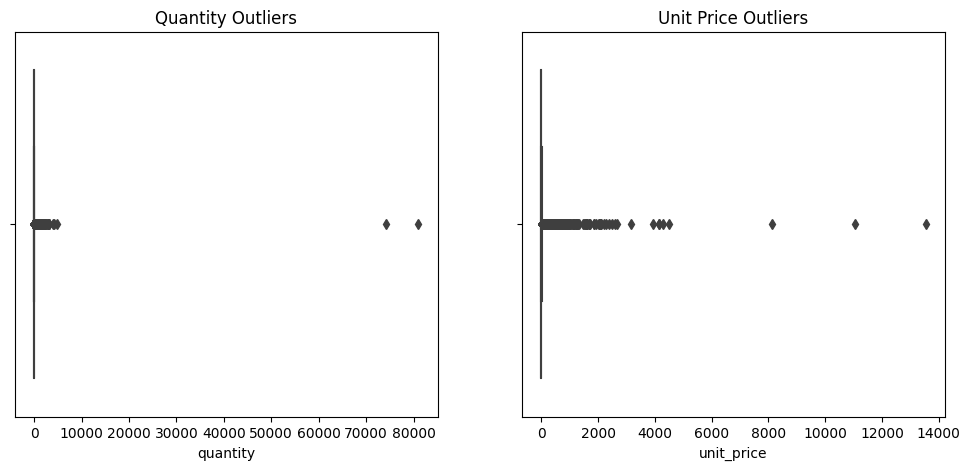

In [21]:
# Boxplot for quantity and unit price
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['quantity'])
plt.title('Quantity Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['unit_price'])
plt.title('Unit Price Outliers')

plt.show()

In [22]:
# Define function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from quantity and unit price
df = remove_outliers(df, 'quantity')
df = remove_outliers(df, 'unit_price')


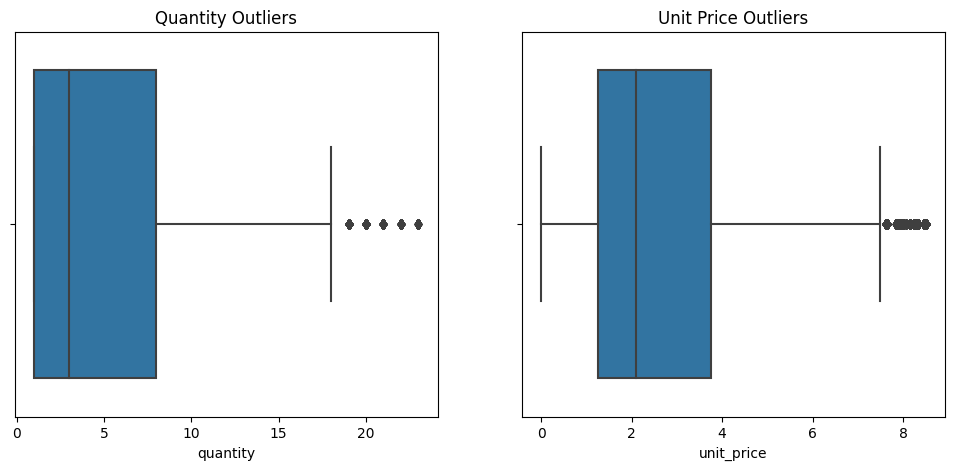

In [24]:
# Boxplot for quantity and unit price
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['quantity'])
plt.title('Quantity Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['unit_price'])
plt.title('Unit Price Outliers')

plt.show()

In [26]:
df['total'] = df['quantity'] * df['unit_price']

# calculate daily sales
daily_sales = df.groupby(df['invoice_date'].dt.date)['total'].sum().reset_index()
daily_sales.columns = ['date', 'total_sales']

# Set the date as index
daily_sales.set_index('date', inplace=True)

In [33]:
daily_sales.head()

,total_sales
date,
2010-12-01,25826.43
2010-12-02,21323.47
2010-12-03,20970.18
2010-12-05,20686.95
2010-12-06,31306.43


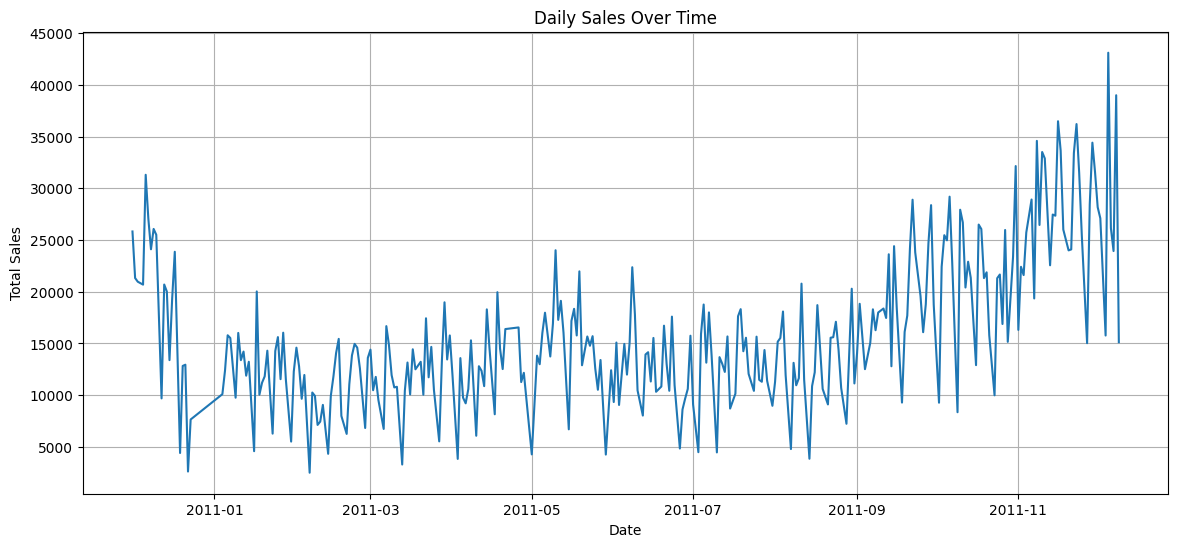

In [41]:
plt.figure(figsize=(14, 6))
plt.plot(daily_sales.index, daily_sales['total_sales'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [42]:
from statsmodels.tsa.stattools import adfuller

# Check for stationarity (constant mean and variance) using the ADF test
result = adfuller(daily_sales['total_sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] > 0.05:
    print("The data is non-stationary. Consider differencing.")
else:
    print("The data is stationary.")


ADF Statistic: -0.6843341449208635
p-value: 0.8507657255099694
The data is non-stationary. Consider differencing.


In [43]:
# Apply first-order differencing
daily_sales_diff = daily_sales['total_sales'].diff().dropna()

# Check for stationarity again using ADF test
result = adfuller(daily_sales_diff)
print('ADF Statistic after differencing:', result[0])
print('p-value after differencing:', result[1])
if result[1] > 0.05:
    print("The data is still non-stationary. Consider differencing again.")
else:
    print("The data is now stationary.")


ADF Statistic after differencing: -6.026005113007836
p-value after differencing: 1.4554491497143075e-07
The data is now stationary.


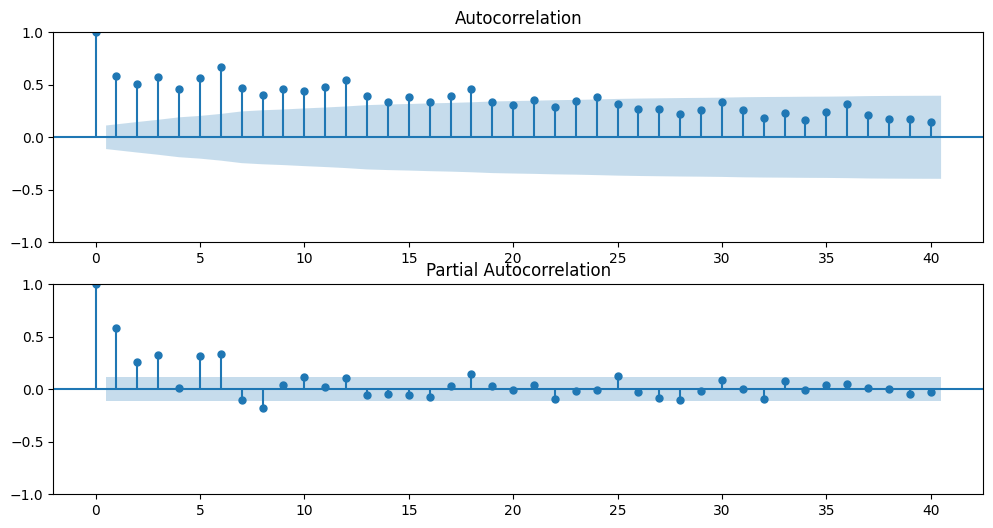

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(daily_sales['total_sales'], ax=plt.gca(), lags=40)
plt.subplot(212)
plot_pacf(daily_sales['total_sales'], ax=plt.gca(), lags=40)
plt.show()


In [45]:
pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [47]:
from pmdarima import auto_arima

# Fit auto_arima to find the optimal (p, d, q)
auto_model = auto_arima(daily_sales['total_sales'], seasonal=False, trace=True)
print(auto_model.summary())

# Get the best (p, d, q) order
best_order = auto_model.order


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6050.644, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6202.805, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6145.614, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6053.620, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6200.816, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6051.574, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6056.124, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6052.630, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6036.914, Time=0.80 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6054.026, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6033.142, Time=0.46 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5998.196, Time=0.45 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=6009.073, Time=0.93 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=5999.489, Time=1.11 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept

In [54]:
model = ARIMA(daily_sales['total_sales'], order=(5, 1, 2), trend='ctt')

# Fit the model
arima_result = model.fit()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [51]:


# Step 4: Make Future Predictions
# Forecast the next 30 days
forecast = arima_result.get_forecast(steps=30)
forecast_index = pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1), periods=30)
forecast_values = forecast.predicted_mean

# Step 5: Plot the Forecast
plt.figure(figsize=(14, 6))
plt.plot(daily_sales.index, daily_sales['total_sales'], label='Historical Sales')
plt.plot(forecast_index, forecast_values, label='Forecasted Sales', color='red')
plt.title('Sales Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

# Step 6: Evaluate the Model
# Train-test split (use the last 30 days as a test set)
train = daily_sales.iloc[:-30]
test = daily_sales.iloc[-30:]

# Fit the model on the training set
model = ARIMA(train['total_sales'], order=(5, 1, 2), trend=1)
arima_result = model.fit()

# Make predictions on the test set
forecast_test = arima_result.get_forecast(steps=30)
y_pred = forecast_test.predicted_mean

# Extract the actual values
y_true = test['total_sales'].values

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


ValueError: Valid trend inputs are 'c' (constant), 't' (linear trend in time), 'ct' (both), 'ctt' (both with trend squared) or an interable defining a polynomial, e.g., [1, 1, 0, 1] is `a + b*t + ct**3`. Received 1

In [ ]:
# Step 7: Save the Model
joblib.dump(arima_result, 'models/sales_forecast_arima_model.pkl')